In [ ]:
import os
import re
from random import sample, randint

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Base Model

In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as f:
    text = f.readlines()

text = [x.replace('\t\t', '') for x in text]

--2022-12-25 14:30:04--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2022-12-25 14:30:05 (11.7 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In [ ]:
print(f"{len(text)} lines")
text[:20]

7088 lines


['\n',
 'I\n',
 '\n',
 '«Мой дядя самых честных правил,\n',
 'Когда не в шутку занемог,\n',
 'Он уважать себя заставил\n',
 'И лучше выдумать не мог.\n',
 'Его пример другим наука;\n',
 'Но, боже мой, какая скука\n',
 'С больным сидеть и день и ночь,\n',
 'Не отходя ни шагу прочь!\n',
 'Какое низкое коварство\n',
 'Полуживого забавлять,\n',
 'Ему подушки поправлять,\n',
 'Печально подносить лекарство,\n',
 'Вздыхать и думать про себя:\n',
 'Когда же черт возьмет тебя!»\n',
 '\n',
 '\n',
 '\n']

In [ ]:
text = [s for s in text if s != '\n']
print(f"{len(text)} lines")

5615 lines


In [ ]:
#text = [re.sub("[^а-яА-Я]+", " ", s).lower() for s in text]
#print(f"{len(text)} lines")
#text = [s.lstrip() for s in text if s != " "]
#print(f"{len(text)} lines")

# text = [re.sub('[IVXLCDM]+', '', s) for s in text]  # dummy roman numerals remove
# https://dev.to/alexdjulin/a-python-regex-to-validate-roman-numerals-2g99
text = [re.sub('^M{0,3}(CM|CD|D?C{0,3})?(XC|XL|L?X{0,3})?(IX|IV|V?I{0,3})?$', '', s) for s in text]
text = [re.sub('[^a-zA-Zа-яА-Я.,;:?’!-]+', ' ', s) for s in text]
text = [s.lstrip().lower() for s in text if len(s) > 1]
print(f"{len(text)} lines")
text[:8]

5257 lines


['мой дядя самых честных правил, ',
 'когда не в шутку занемог, ',
 'он уважать себя заставил ',
 'и лучше выдумать не мог. ',
 'его пример другим наука; ',
 'но, боже мой, какая скука ',
 'с больным сидеть и день и ночь, ',
 'не отходя ни шагу прочь! ']

In [ ]:
headers = ('Письмо Татьяны к Онегину', 'Письмо Онегина к Татьяне',
           'Глава первая', 'Глава вторая', 'Глава третья', 'Глава четвертая',
           'Глава пятая', 'Глава шестая', 'Глава седьмая', 'Глава восьмая')
text = [s for s in text if s not in map(lambda x: f'{x} '.lower(), headers)]
print(f"{len(text)} lines")

5251 lines


In [ ]:
# https://en.wikipedia.org/wiki/Onegin_stanza
# https://en.wikipedia.org/wiki/Iamb_(poetry)
text = [''.join(text[i:i+2]).strip() for i in range(0, len(text), 2)]   # Iamb
print(f"{len(text)} lines")
text[:8]

2626 lines


['мой дядя самых честных правил, когда не в шутку занемог,',
 'он уважать себя заставил и лучше выдумать не мог.',
 'его пример другим наука; но, боже мой, какая скука',
 'с больным сидеть и день и ночь, не отходя ни шагу прочь!',
 'какое низкое коварство полуживого забавлять,',
 'ему подушки поправлять, печально подносить лекарство,',
 'вздыхать и думать про себя: когда же черт возьмет тебя!',
 'так думал молодой повеса, летя в пыли на почтовых,']

In [ ]:
# Join all the strings into one and lowercase it
out = ' '.join(text)
out[:106]

'мой дядя самых честных правил, когда не в шутку занемог, он уважать себя заставил и лучше выдумать не мог.'

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(out))

In [ ]:
tokens.append('<') # <SOS> token
tokens.append('>') # <EOS> token
tokens.append('_') # <PAD> token

In [ ]:
len(tokens)

69

Create dictionary `token_to_idx = {: }` and dictionary `idx_to_token = {: }`

In [ ]:
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: token for token, idx in token_to_idx.items()}
print(token_to_idx, idx_to_token, sep='\n')

{' ': 0, '!': 1, ',': 2, '-': 3, '.': 4, ':': 5, ';': 6, '?': 7, 'a': 8, 'b': 9, 'c': 10, 'd': 11, 'e': 12, 'f': 13, 'g': 14, 'h': 15, 'i': 16, 'k': 17, 'l': 18, 'm': 19, 'n': 20, 'o': 21, 'p': 22, 'q': 23, 'r': 24, 's': 25, 't': 26, 'u': 27, 'v': 28, 'w': 29, 'x': 30, 'y': 31, 'z': 32, 'а': 33, 'б': 34, 'в': 35, 'г': 36, 'д': 37, 'е': 38, 'ж': 39, 'з': 40, 'и': 41, 'й': 42, 'к': 43, 'л': 44, 'м': 45, 'н': 46, 'о': 47, 'п': 48, 'р': 49, 'с': 50, 'т': 51, 'у': 52, 'ф': 53, 'х': 54, 'ц': 55, 'ч': 56, 'ш': 57, 'щ': 58, 'ъ': 59, 'ы': 60, 'ь': 61, 'э': 62, 'ю': 63, 'я': 64, '’': 65, '<': 66, '>': 67, '_': 68}
{0: ' ', 1: '!', 2: ',', 3: '-', 4: '.', 5: ':', 6: ';', 7: '?', 8: 'a', 9: 'b', 10: 'c', 11: 'd', 12: 'e', 13: 'f', 14: 'g', 15: 'h', 16: 'i', 17: 'k', 18: 'l', 19: 'm', 20: 'n', 21: 'o', 22: 'p', 23: 'q', 24: 'r', 25: 's', 26: 't', 27: 'u', 28: 'v', 29: 'w', 30: 'x', 31: 'y', 32: 'z', 33: 'а', 34: 'б', 35: 'в', 36: 'г', 37: 'д', 38: 'е', 39: 'ж', 40: 'з', 41: 'и', 42: 'й', 43: 'к', 4

In [ ]:
# batch of sequences:
# |__________sequence1__________|
# |_____sequence2_____|_padding_|
# |___sequence3___|___padding___|
# ...

def to_matrix(text, max_len=None, pad=token_to_idx['_'], dtype='int32', batch_first=True):
    """Casts a list of names into RNN-digestable matrix"""
    max_len = max_len or max(map(len, text))  # max_len in batch
    max_len += 1  # because we add <EOS> to each line
    text_ix = np.zeros([len(text), max_len], dtype) + pad  # <PAD> initialization
    text_ix[:, 0] = token_to_idx['<']  # add <SOS> token

    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, 0:len(line_ix)] = line_ix
        text_ix[i, len(line_ix)] = token_to_idx['>']  # add <EOS> token

    if not batch_first:  # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    return text_ix

In [ ]:
# Example: cast random names to matrices, pad with zeros
print('\n'.join(text[::1000]))
mat = to_matrix(text[::1000])
print(mat, '\n', mat.shape)

мой дядя самых честных правил, когда не в шутку занемог,
желаньем медленно томим, томим и ветреным успехом,
под шляпой с пасмурным челом, с руками, сжатыми крестом.
[[45 47 42  0 37 64 37 64  0 50 33 45 60 54  0 56 38 50 51 46 60 54  0 48
  49 33 35 41 44  2  0 43 47 36 37 33  0 46 38  0 35  0 57 52 51 43 52  0
  40 33 46 38 45 47 36  2 67]
 [39 38 44 33 46 61 38 45  0 45 38 37 44 38 46 46 47  0 51 47 45 41 45  2
   0 51 47 45 41 45  0 41  0 35 38 51 49 38 46 60 45  0 52 50 48 38 54 47
  45  2 67 68 68 68 68 68 68]
 [48 47 37  0 57 44 64 48 47 42  0 50  0 48 33 50 45 52 49 46 60 45  0 56
  38 44 47 45  2  0 50  0 49 52 43 33 45 41  2  0 50 39 33 51 60 45 41  0
  43 49 38 50 51 47 45  4 67]] 
 (3, 57)


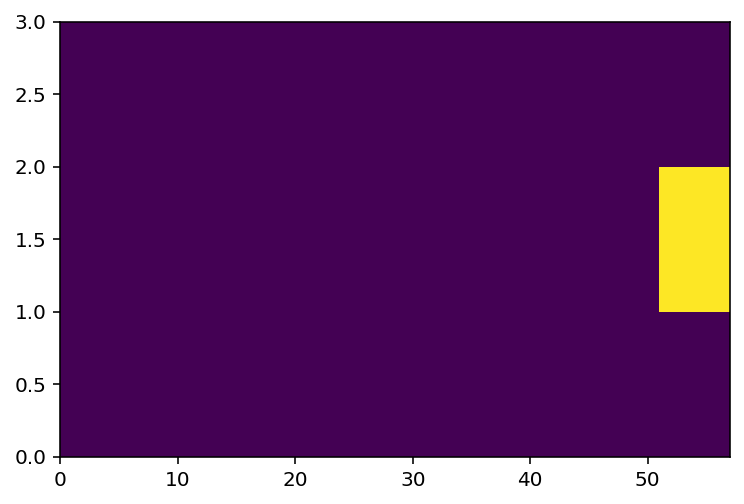

In [ ]:
plt.pcolormesh(to_matrix(text[::1000]) == token_to_idx['_']);  # show <PAD> tokens

Now we want to build and train recurrent neural net which would be able to something similar to Pushkin's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$  and previous RNN state $h_t$. This is exactly what we're gonna do now.

Since we're training a language model, there should also be:

- An embedding layer that converts character id $x_t$ to a vector.
- An output layer that predicts probabilities of next phoneme

In [ ]:
# one-hot encoding alternative
embed = nn.Embedding(4, 2)
print(embed, '\n')
print(next(embed.parameters()), '\n')  # params
print(embed(torch.LongTensor([2])))  # access elements

Embedding(4, 2) 

Parameter containing:
tensor([[-0.5533,  0.9856],
        [-1.2083,  0.3059],
        [-1.4542,  0.4938],
        [-0.1625, -0.7225]], requires_grad=True) 

tensor([[-1.4542,  0.4938]], grad_fn=<EmbeddingBackward0>)


In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=32, rnn_num_units=64):
        super().__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)  # token vector representation (trainable)
        # A simple lookup table that stores embeddings of a fixed dictionary and size.
        # This module is often used to store word embeddings and retrieve them using indices.
        # The input to the module is a list of indices, and the output is the corresponding word embeddings.
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # x: torch.Size([b_sz])
        x_emb = self.embedding(x)
        # x_emb: torch.Size([b_sz, emb_sz])

        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        # x_and_h: torch.Size([b_sz, emb_sz + num_units])
        h_next = self.rnn_update(x_and_h)
        # h_next: torch.Size([b_sz, num_units])
        h_next = torch.tanh(h_next)
        assert h_next.size() == h_prev.size()

        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        # logits: torch.Size([b_sz, num_tokens])

        return h_next, logits

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True) + token_to_idx[' ']  # spaces

In [ ]:
char_rnn = CharRNNCell(num_tokens=len(tokens))

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [ ]:
# RNN loop
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in batch_ix
    :param batch_ix: an int32 matrix of shape [batch, time], output of to_matrix(text)
    """
    # batch_ix: torch.Size([bs, max_len])
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    # passing `bs` sequences through the network
    for x_t in batch_ix.transpose(0, 1):
        # batch_ix.transpose(0, 1) -> torch.Size([max_len, bs])
        # x_t: torch.Size([bs])
        hid_state, logits_next = char_rnn(x_t, hid_state)  # passing `bs` characters
        logits.append(logits_next)

    return torch.stack(logits, dim=1)

In [ ]:
batch_ix = to_matrix(text[:5])  # b_sz=5
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
print(batch_ix.shape)  # torch.Size([b_sz, max_len])

logit_seq = rnn_loop(char_rnn, batch_ix)
print(logit_seq.shape)  # torch.Size([b_sz, max_len, num_tokens])

torch.Size([5, 57])
torch.Size([5, 57, 69])


We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` – a matrix of token ids shifted 1 step to the left so i-th element is acutally the "next token" for i-th prediction.

In [ ]:
predictions_logits = logit_seq[:, :-1]
print(predictions_logits.shape)
actual_next_tokens = batch_ix[:, 1:]
print(actual_next_tokens.shape)
num_tokens = len(tokens)

loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])
# ignore gradients for this tokens (no <PAD> predictions)
loss = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1),
)
print(loss.item())
loss.backward()

torch.Size([5, 56, 69])
torch.Size([5, 56])
4.232661247253418


In [ ]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        f"Loss is not differentiable w.r.t. a weight with shape f{w.size()}. Check forward method."

We train our char-rnn exactly the same way we train any deep learning model: by minibatch SGD.

The only difference is that this time we sample strings, not images or sound.

In [ ]:
BATCH_SIZE = 32
MAX_LENGTH = max(map(len, text))
print(MAX_LENGTH)

104


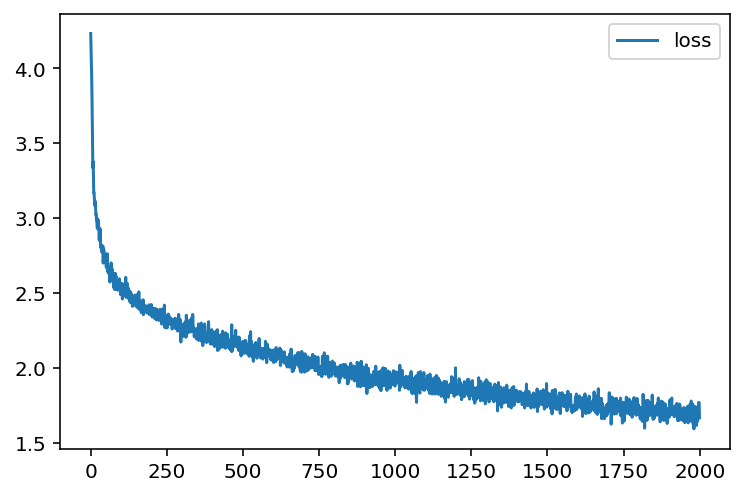

In [ ]:
char_rnn = CharRNNCell(num_tokens=len(tokens), embedding_size=64, rnn_num_units=256)
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])

history = []

for i in range(2000):
    batch_ix = to_matrix(sample(text, BATCH_SIZE), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logits_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(
        predictions_logits.reshape((-1, num_tokens)),
        actual_next_tokens.reshape(-1),
    )

    loss.backward()
    opt.step()

    opt.zero_grad()

    history.append(loss.item())
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Once we've trained our network a bit, let's get to actually generating stuff. All we need is the single rnn step function you have defined in `char_rnn.forward`.

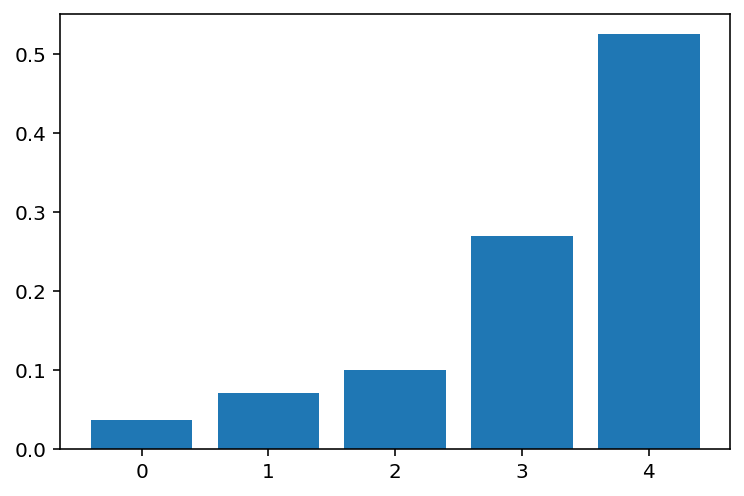

In [ ]:
# temperature concept
def softmax(x, temp=1.):
    exps = np.exp((x - x.max()) / temp)
    return exps / exps.sum()

plt.bar(np.arange(5), softmax(np.array([1, 3, 4, 7, 9]), temp=3));

In [ ]:
def generate_sample(char_rnn, seed_phrase='<', max_length=32, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    # x_sequence: torch.Size([1, 1])
    hid_state = char_rnn.initial_state(batch_size=1)
    # hid_state: torch.Size([1, 256])

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        # hid_state: torch.Size([1, rnn_num_units])
        # logits_next: torch.Size([1, num_tokens])
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]
        # p_next: (num_tokens,)

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        if next_ix == token_to_idx['>']:
            break

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
generate_sample(
            char_rnn, temperature=0.2, seed_phrase='<', max_length=MAX_LENGTH,
)[1:-1]

'аль сон был не поэта света, в нем не слушал сердца с ней не послушный волненье в нем и верно, и сладко'

In [ ]:
seed_phrases = ['<онегин', '<добрый', '<мой', '<приятель', '<родился', '<на', '<брегах', '<невы']
for phrase in seed_phrases:
    print(
        generate_sample(
            char_rnn, temperature=0.1, seed_phrase=phrase, max_length=MAX_LENGTH,
        )[1:-1]
    )

онегин след, и в том обеданья, и в том он сердце подруга под ней надежды слава был на старинный пора н
добрый следом, и в сердце подруга под ней надежды следом, и в том обеданья, не волненье в ней на вольн
мой страсть и в том подруга под ней надежды слава бого не привычной души моей страстный проказы ль вер
приятельный света с ней не послушно простой, что ж нет онегин след, и в том пора не слушал он слушал о
родился он верно в ней сердце в нем судьба моя девицы не привычкой страстный мой онегин славить вот бе
на слушал он верной души моей страстный мой она под ней не послушный простите в ней надежды следом он 
брегах не послушный след, и в том обманали в нем и верно в ней на душа в том под ней надежды слезами с
невы, и в том обеданья, все друзья, не после слушал и в том он слушал он слушал он слушал сердце подру


# More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as f:
    text = f.readlines()

text = [x.replace('\t\t', '') for x in text]

In [ ]:
with open('onegin.txt', 'r') as f:
    text = f.readlines()

text = [x.replace('\t\t', '') for x in text]

print(f"{len(text)} lines")
text = [re.sub('^M{0,3}(CM|CD|D?C{0,3})?(XC|XL|L?X{0,3})?(IX|IV|V?I{0,3})?$', '', s) for s in text]
text = [re.sub('[^a-zA-Zа-яА-Я.,;:?’!-]+', ' ', s) for s in text]
text = [s.lstrip().lower() for s in text if len(s) > 1]

headers = ('Письмо Татьяны к Онегину', 'Письмо Онегина к Татьяне',
           'Глава первая', 'Глава вторая', 'Глава третья', 'Глава четвертая',
           'Глава пятая', 'Глава шестая', 'Глава седьмая', 'Глава восьмая')
text = [s for s in text if s not in map(lambda x: f'{x} '.lower(), headers)]
print(f"{len(text)} lines")

text = [''.join(text[i:i+2]).strip() for i in range(0, len(text), 2)]   # Iamb
print(f"{len(text)} lines")
text[:8]

7088 lines
5251 lines
2626 lines


['мой дядя самых честных правил, когда не в шутку занемог,',
 'он уважать себя заставил и лучше выдумать не мог.',
 'его пример другим наука; но, боже мой, какая скука',
 'с больным сидеть и день и ночь, не отходя ни шагу прочь!',
 'какое низкое коварство полуживого забавлять,',
 'ему подушки поправлять, печально подносить лекарство,',
 'вздыхать и думать про себя: когда же черт возьмет тебя!',
 'так думал молодой повеса, летя в пыли на почтовых,']

In [ ]:
out = ' '.join(text)
out[:106]

'мой дядя самых честных правил, когда не в шутку занемог, он уважать себя заставил и лучше выдумать не мог.'

In [ ]:
tokens = sorted(set(out))
len(tokens)

66

In [ ]:
# tokenize (no <PAD> <SOS> <EOS> tokens)
token_to_idx = {char: idx for idx, char in enumerate(tokens)}
idx_to_token = {idx: char for char, idx in token_to_idx.items()}
char_sequence = np.array([token_to_idx[char] for char in out])
len(char_sequence)  # all characters codes

137644

In [ ]:
# batch generator (MAX_LENGTH strings)
BATCH_SIZE = 32
MAX_LENGTH = 128

def generate_batch(char_sequence, batch_size=BATCH_SIZE, max_len=MAX_LENGTH):
    train, target = [], []
    for _ in range(batch_size):
        start_idx = randint(0, len(char_sequence) - max_len - 2)
        seq_chunk = char_sequence[start_idx:start_idx + max_len + 1]
        # train data
        train_part = torch.tensor(seq_chunk[:-1], dtype=torch.int64)  # torch.Size([max_len])
        train.append(train_part)

        # target -> shifted sequence
        target_part = torch.tensor(seq_chunk[1:], dtype=torch.int64)  # torch.Size([max_len])
        target.append(target_part)

    return torch.stack(train, dim=0), torch.stack(target, dim=0)  # torch.Size([b_sz, max_len]), torch.Size([b_sz, max_len])

In [ ]:
# nn.Embedding indexing example
emb1 = nn.Embedding(5, 4)  # num_tokens=5, emb_sz=4
print(next(emb1.parameters()))
inp1 = torch.randint(5, (3, 2))  # b_sz=3, max_len=2
print(inp1)
emb1(inp1)  # input: IntTensor or LongTensor of arbitrary shape containing the indices to extract

Parameter containing:
tensor([[-1.6154,  0.8460, -1.8024,  1.1635],
        [-1.0729,  0.7613, -0.6821, -0.6500],
        [ 0.8707, -0.6078, -0.2569, -0.0121],
        [ 0.9894,  0.7269,  1.4208,  0.6669],
        [-1.6712, -0.3635, -0.1114,  0.3008]], requires_grad=True)
tensor([[3, 3],
        [1, 0],
        [4, 1]])


tensor([[[ 0.9894,  0.7269,  1.4208,  0.6669],
         [ 0.9894,  0.7269,  1.4208,  0.6669]],

        [[-1.0729,  0.7613, -0.6821, -0.6500],
         [-1.6154,  0.8460, -1.8024,  1.1635]],

        [[-1.6712, -0.3635, -0.1114,  0.3008],
         [-1.0729,  0.7613, -0.6821, -0.6500]]], grad_fn=<EmbeddingBackward0>)

[LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

Applies a multi-layer long short-term memory (LSTM) RNN to an input sequence.

Parameters:

- `input_size` – The number of expected features in the input $x$

- `hidden_size` – The number of features in the hidden state $h$

- `num_layers` – Number of recurrent layers. E.g., setting `num_layers=2` would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1

- `bias` – If `False`, then the layer does not use bias weights b_ih and b_hh. Default: `True`

- `batch_first` – If `True`, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: `False`

- `dropout` – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to `dropout`. Default: 0

- `bidirectional` – If `True`, becomes a bidirectional LSTM. Default: `False`

- `proj_size` – If > 0, will use LSTM with projections of corresponding size. Default: 0

Inputs: `input, (h_0, c_0)`

- `input`: tensor of shape $(L, H_{in})$ for unbatched input, $(L, N, H_{in})$ when `batch_first=False` or $(N, L, H_{in})$ when `batch_first=True` containing the features of the input sequence.

- `h_0`: tensor of shape $(D * num\_layers, H_{out})$ for unbatched input or $(D * num\_layers, N, H_{out})$ containing the initial hidden state for each element in the input sequence. Defaults to zeros if `(h_0, c_0)` is not provided.

- `c_0`: tensor of shape $(D * num\_layers, H_{cell})$ for unbatched input or $(D * num\_layers, N, H_{cell})$ containing the initial cell state for each element in the input sequence. Defaults to zeros if `(h_0, c_0)` is not provided.

  where:

  $N$ = batch size

  $L$ = sequence length

  $D$ = 2 if `bidirectional=True` otherwise 1

  $H_{in}$ = input size

  $H_{cell}$ = hidden size

  $H_{out}$ `proj_size` if `proj_size` > 0 otherwise `hidden_size`.

Outputs: `output, (h_n, c_n)`

- `output`: tensor of shape $(L, D * H_{out})$ for unbatched input, $(L, N, D * H_{out})$ when `batch_first=False` or $(N, L, D * H_{out})$ when `batch_first=True` containing the output features (`h_t`) from the last layer of the LSTM, for each $t$. When `bidirectional=True`, `output` will contain a concatenation of the forward and reverse hidden states at each time step in the sequence.

- `h_n`: tensor of shape $(D * num\_layers, H_{out})$ for unbatched input or $(D * num\_layers, N, H_{out})$ containing the final hidden state for each element in the sequence. When `bidirectional=True`, `h_n` will contain a concatenation of the final forward and reverse hidden states, respectively.

- `c_n`: tensor of shape $(D * num\_layers, H_{cell})$ for unbatched input or $(D * num\_layers, N, H_{cell})$ containing the final cell state for each element in the sequence. When `bidirectional=True`, `c_n` will contain a concatenation of the final forward and reverse cell states, respectively.

In [ ]:
class CharRNNlstm(nn.Module):
    def __init__(self, num_tokens, hidden_size=256, embedding_size=64,
                 num_layers=1, dropout=0):
        super().__init__()
        self.num_tokens = num_tokens
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(self.num_tokens, self.embedding_size)
        self.lstm = nn.LSTM(
            input_size=self.embedding_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(self.hidden_size, self.num_tokens)

    def forward(self, x, hidden):  # hidden = (h_0, c_0)
        # x: torch.Size([b_sz, max_len])
        x = self.embedding(x)
        # x: torch.Size([b_sz, max_len, emb_sz])
        out, (h_n, c_n) = self.lstm(x, hidden)
        # out: torch.Size([b_sz, max_len, num_tokens])
        # h_n: torch.Size([num_layers, b_sz, hidden_size])
        # c_n: torch.Size([num_layers, b_sz, hidden_size])
        x = self.fc(out)
        # x: torch.Size([b_sz, hidden_size, num_tokens])
        return x, (h_n, c_n)

    def init_hidden(self, batch_size=1):
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=True) + token_to_idx[' ']
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=True) + token_to_idx[' ']  # spaces
        return (h_0 , c_0)

In [ ]:
# check outputs
char_rnn_lstm = CharRNNlstm(num_tokens=len(idx_to_token), hidden_size=256, embedding_size=64, num_layers=2)
train, target = generate_batch(char_sequence, batch_size=BATCH_SIZE, max_len=MAX_LENGTH)
h_0, c_0 = char_rnn_lstm.init_hidden(batch_size=BATCH_SIZE)
out, (h_n, c_n) = char_rnn_lstm(train, (h_0, c_0))
print(out.shape, h_n.shape, c_n.shape)

torch.Size([32, 128, 66]) torch.Size([2, 32, 256]) torch.Size([2, 32, 256])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


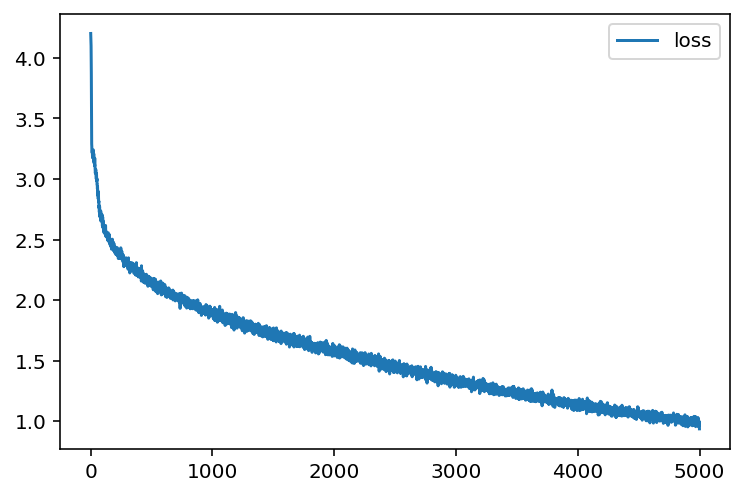

training: 100%|██████████| 5000/5000 [01:39<00:00, 50.22it/s]


In [ ]:
char_rnn_lstm = CharRNNlstm(
    num_tokens=len(idx_to_token),
    hidden_size=256, embedding_size=64,
    num_layers=2, dropout=0.25,
)
char_rnn_lstm.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(char_rnn_lstm.parameters(), amsgrad=True)

NUM_EPOCHS = 5000
history = []

for epoch in tqdm(range(NUM_EPOCHS), total=NUM_EPOCHS, desc="training"):
    char_rnn_lstm.train()
    train, target = generate_batch(char_sequence, batch_size=BATCH_SIZE, max_len=MAX_LENGTH)
    # train, target: torch.Size([b_sz, max_len])
    h_n, c_n = char_rnn_lstm.init_hidden(batch_size=BATCH_SIZE)

    out, (h_n, c_n) = char_rnn_lstm(train.to(device), (h_n.to(device), c_n.to(device)))
    # out: torch.Size([b_sz, max_len, num_tokens])

    loss = criterion(
        out.reshape(-1, len(idx_to_token)),  # torch.Size([b_sz * max_len, num_tokens)
        target.reshape(-1).to(device),  # torch.Size([b_sz * max_len])
    )

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    history.append(loss.item())
    if (epoch + 1) % 50 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

In [ ]:
def generate_sample(model, token_to_idx, idx_to_token, seed_text=' ', prediction_len=128, temperature=1.0):
    model.eval().cpu()
    h_n, c_n = model.init_hidden(batch_size=1)
    seed_input = [token_to_idx[char] for char in seed_text]
    seed_t = torch.LongTensor(seed_input).unsqueeze(0)
    # seed_t: torch.Size([1, len(seed_text)])
    pred_text = seed_text
    out, (h_n, c_n) = model(seed_t, (h_n, c_n))
    # out: torch.Size([1, len(seed_text), num_tokens])
    inp = seed_t[:,-1].unsqueeze(0)
    # inp: torch.Size([1, 1])

    for i in range(prediction_len):
        out, (h_n, c_n) = model(inp, (h_n, c_n))
        # out: torch.Size([1, 1, num_tokens])
        out_logits = out.squeeze()
        # out_logits: torch.Size([num_tokens])
        p_next = F.softmax(out_logits / temperature, dim=-1).data.numpy()
        # p_next: (num_tokens,)
        top_idx = np.random.choice(len(token_to_idx), p=p_next)  # int
        inp = torch.LongTensor([top_idx]).unsqueeze(0)
        # inp: torch.Size([1, 1])
        pred_char = idx_to_token[top_idx]
        pred_text += pred_char

    return pred_text

In [ ]:
generate_sample(char_rnn_lstm, token_to_idx, idx_to_token, seed_text='ложился на поля туман,', temperature=0.1)

'ложился на поля туман, уверен, кто в ней не видит она свои прочел и тихо слезы льет и в семье родной долгой верит и в старины и нет, иль нет не потому'

In [ ]:
generate_sample(char_rnn_lstm, token_to_idx, idx_to_token, seed_text='уж небо осенью дышало,', temperature=0.1)

'уж небо осенью дышало, и все долго лишь пред ней онегин в самом душу погружен гостил. она своих, и все родне ей души в семье своей родной подруга стол'

Generate text using the trained net with different temperature parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
for tmp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(
        f'tmp {tmp}:',
        generate_sample(
            char_rnn_lstm, token_to_idx, idx_to_token, seed_text=' ', temperature=tmp,
        )
    )

tmp 0.1:  волненье в ней не полку с ней волненье света к ней не знала б тайну с нею последней постелей, кто ни был он из вот уж нет. меж т
tmp 0.2:  отворилась, и так же скучной татьяны преданный край летит, вс полность воздушном странной страсти меня света, моей татьяне пред 
tmp 0.5:  волненье света богой забор. и тайну с нею ваше и в любя, люблю татьяну прошла от друзья, и посленный метветы беспечны, над нею ч
tmp 1.0:  приняться. мильянка вотрилась и в селений молодой, и пестни, мнирав, тот говорил: вы, ободританья, бывало? другий, где смусино д
tmp 2.0:  чыдарьх, иских на: гчась: чувзящию журналто. qуn пы зимня гей, умых, поожинчицы, вы не лун. его дочакшеан, мостливы зобла; енее 


As the temperature increases, so does the entropy.

Save the model to the disk, then load it and generate text.

In [ ]:
torch.save(char_rnn_lstm.state_dict(), '/content/drive/MyDrive/onegin_lstm.pt')

In [ ]:
char_rnn_lstm = CharRNNlstm(num_tokens=len(idx_to_token), hidden_size=256, embedding_size=64, num_layers=2)
char_rnn_lstm.load_state_dict(torch.load('/content/drive/MyDrive/onegin_lstm.pt'))
char_rnn_lstm.eval()

CharRNNlstm(
  (embedding): Embedding(66, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=66, bias=True)
)

In [ ]:
generate_sample(char_rnn_lstm, token_to_idx, idx_to_token, seed_text='ложился на поля туман,', temperature=0.40)

'ложился на поля туман, где грустным поэтам подобей себе слушайте с ней ни с веков своей красов и бурь пестрых и за столом с колькой странным снег, пок'

In [ ]:
generate_sample(char_rnn_lstm, token_to_idx, idx_to_token, seed_text='встает заря во мгле холодной', temperature=0.33)

'встает заря во мгле холодной; но уж как будто бездной тишины, и вы, заветных лет, любиль главор, как будто бродит, любовь не постижной собеновенье, которых '

In [ ]:
generate_sample(char_rnn_lstm, token_to_idx, idx_to_token, seed_text='по петербургской мостовой', temperature=0.25)

'по петербургской мостовой, у нас невольно судьба евгений мой, чтоб не принуждена; давно ли домой. придет и нам привык перед собою светают порой; и столь '

## Big LSTM

In [ ]:
import copy

In [ ]:
!mkdir models

ep 10000: ложился на поля туман, гусей крикливых караван тянулся к югу: приближалась довольно скучная пора; стоял ноябрь уж у двора. встает заря во мгле холодной; на нивах шум работ умолк; с своей волчихою голодной выходит на дорогу волк; его почуя, конь дорожный храпит и путник осторожн


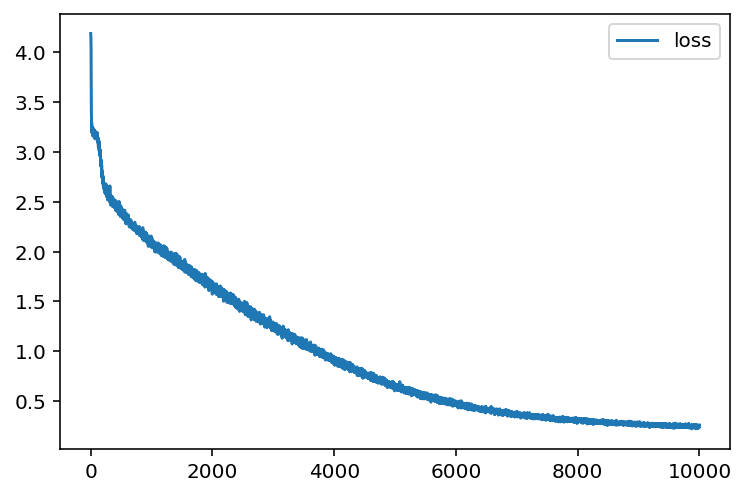

training: 100%|██████████| 10000/10000 [12:24<00:00, 13.43it/s]


In [ ]:
char_rnn_lstm = CharRNNlstm(
    num_tokens=len(idx_to_token),
    hidden_size=512, embedding_size=64,
    num_layers=3, dropout=0.25,
)
char_rnn_lstm.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(char_rnn_lstm.parameters(), lr=3e-4, amsgrad=True)

NUM_EPOCHS = 10000
history = []

for epoch in tqdm(range(NUM_EPOCHS), total=NUM_EPOCHS, desc="training"):
    char_rnn_lstm.train()
    train, target = generate_batch(char_sequence, batch_size=BATCH_SIZE, max_len=MAX_LENGTH)
    # train, target: torch.Size([b_sz, max_len])
    h_n, c_n = char_rnn_lstm.init_hidden(batch_size=BATCH_SIZE)

    out, (h_n, c_n) = char_rnn_lstm(train.to(device), (h_n.to(device), c_n.to(device)))
    # out: torch.Size([b_sz, max_len, num_tokens])

    loss = criterion(
        out.reshape(-1, len(idx_to_token)),  # torch.Size([b_sz * max_len, num_tokens)
        target.reshape(-1).to(device),  # torch.Size([b_sz * max_len])
    )

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    history.append(loss.item())
    if (epoch + 1) % 50 == 0:
        clear_output(True)
        model_copy = copy.deepcopy(char_rnn_lstm).eval().cpu()
        model_num = f'{epoch + 1}'.zfill(len(str(NUM_EPOCHS)))
        torch.save(model_copy.state_dict(), f'models/model_ep{model_num}.pt')
        gen_sample = generate_sample(
            model_copy, token_to_idx, idx_to_token,
            seed_text='ложился на поля туман,',
            prediction_len=256, temperature=0.1,
        )
        log_text = f'ep {epoch + 1}: {gen_sample}'
        print(log_text)
        with open('models_log.txt', 'a') as f:
            f.write(log_text + '\n')
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

In [ ]:
# !rm -rf models/*
# !rm models_log.txt
!cat models_log.txt

ep 50: ложился на поля туман,                                                                                                                                                                                                                                                                
ep 100: ложился на поля туман,                                                    о                  о                                         о                                            о   о                          о                          о                                       
ep 150: ложился на поля туман, о ооа оо ее оо оа ое ее ооо оо оо о ое ое оо оа оо ое оо оо оо оо ое ое ое оое ое оон о ое оо оо ао ое не оо ооа оо оо оо оо ое ооа ое оо оо ое ое оо оо ое оо ое е ое ое оа ое ое оо ое ое ое оо оо оо ое ое оо оа оо ое оа ое е ооо оо оо ооо оа оо оо оое ое
ep 200: ложился на поля туман, воте стот стот стот стет стот стот пото вет стот потот стоне сроте стот о воте потот пото потет стот вет стот

Epochs:
- 4550, 5550, 5850, 6150 (light overfitting)
- 6650, 7050, 7550, 8050+ (strong overfitting)

`model_ep10000` predictions:

In [ ]:
generate_sample(char_rnn_lstm, token_to_idx, idx_to_token, seed_text='по петербургской мостовой', temperature=0.25)

'по петербургской мостовой и вас покинул мой евгений. отступник бурных наслаждений, онегин дома заперся, зевая, за перо взялся, хотел писать но труд упорн'

In [ ]:
generate_sample(char_rnn_lstm, token_to_idx, idx_to_token, seed_text='идет онегин молодой', temperature=0.25)

'идет онегин молодой. ее души не отуманил: в герою всех разумный перой я стоял не сводит с ольгой вечер отмужи встали совсем; она первым стоком поле'

In [ ]:
char_rnn_lstm = CharRNNlstm(num_tokens=len(idx_to_token), hidden_size=512, embedding_size=64, num_layers=3)
char_rnn_lstm.load_state_dict(torch.load('models/model_ep04400.pt'))
char_rnn_lstm.eval()

CharRNNlstm(
  (embedding): Embedding(66, 64)
  (lstm): LSTM(64, 512, num_layers=3, batch_first=True)
  (fc): Linear(in_features=512, out_features=66, bias=True)
)

In [ ]:
generate_sample(char_rnn_lstm, token_to_idx, idx_to_token, seed_text='по петербургской мостовой', temperature=0.15)

'по петербургской мостовой, о нем нам постыне скучной, иль небосклоне, полно, подъежла с красной лежет, и вот обожный собрался и привора, приятно держест;'

In [ ]:
generate_sample(char_rnn_lstm, token_to_idx, idx_to_token, seed_text='идет онегин молодой', temperature=0.15)

'идет онегин молодой. он полунечких следам и восклицанья, полною дорожбий свет роман возок изорный он протовидая сердца всей чудно нежен. она прочел'

## Markovify

In [ ]:
!pip install markovify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 6.1 MB/s 
  Created wheel for markovify: filename=markovify-0.9.4-py3-none-any.whl size=18627 sha256=c8814a84935eab8e3dc9eca7b04e626f5ce10299bb17ad3adbdb972b122db0ce
  Stored in directory: /root/.cache/pip/wheels/aa/9d/bb/96461cbfde2120f3612c7c2af202976d46542735a2cd8b00f8
Successfully built markovify


In [ ]:
import markovify

In [ ]:
# https://thecode.media/markovify/
# text = open('onegin.txt', encoding='utf8').read()
text_model = markovify.Text(out)

In [ ]:
print(text_model.make_sentence(tries=100)) # tries=100 to avoid `None` result

меж тем разумный толк без пошлых тем, без вечных истин, без педантства, и не заботился о том, какой у дочки тайный том дремал до утра под подушкой.


In [ ]:
for i in range(20):
    print(text_model.make_sentence(tries=100))

но изменяет пеной шумной оно желудку моему, и я любила вас; и что ей душу ни смутило, как сильно ни была она удивлена, поражена, но ей не хорошо на новоселье, привыкшей к горнице своей.
: приди в чертог ко мне писали, не отпирайтесь.
вот мой онегин на свободе; острижен по последней моде; как dandy лондонский одет и наконец в своей постеле скончался б посреди детей, плаксивых баб и лекарей.
и так нимало поутру не был в свете.
редеет сумрак; но она своих полей не различает: пред нею пестрый полк ливрей, или платок подымет ей.
свой пистолет тогда евгений, не уважая сердца в нем, согретой девственным огнем.
не муки тайные злодейства я грозно в нем пыл души бы охладел.
отец ее был добрый малый, в прошедшем веке запоздалый; но в темном зеркале одна дрожит печальная луна чу снег хрустит прохожий; дева к нему с повинной головою.
давно ж ты не был удивлен, когда его увидел он.
для кого ж любить?
но этой страсти и случайно еще никто не слушает, кричат, смеются, спорят и пищат.
однако в поле темн

In [ ]:
for i in range(30):
    print(text_model.make_sentence(tries=100))

и скоро звонкий голос их, ждала татьяна с нетерпеньем, чтоб трепет сердца в ней ни капли толку, глядит она тихонько в щелку, и что ж?
татьяна верила преданьям простонародной старины, и сердца трепетные сны.
он свят для внуков аполлона; по гордой лире альбиона он мне знаком, он мне знаком, он мне знаком, он мне знаком, он мне знаком, он мне родной.
ее привозят и в рыжем парике.
исчезло счастье юных лет, как на больших похоронах; не видя тут ни капли нет его не терпит высший свет.
идут за стол садясь.
еще прозрачные леса как будто громом поражен.
я вас люблю любовью брата и, может быть, она совсем иным развлечена.
нет, лучше и верней в глуши звучнее голос лирный, живее творческие сны.
чудак, попав на пир огромный, уж был неправ, что над любовью робкой, нежной так подшутил вечор небрежно.
моя студенческая келья вдруг озарилась: муза в ней затих, чтобы прошло ланит пыланье.
не так ли я в то время.
свободно дома принимает, в гостях с ним сейчас была так равнодушна, так смела?
четой идут за 

In [ ]:
import json

In [ ]:
!ls drive/MyDrive/ | grep letov

letov.json


In [ ]:
with open('drive/MyDrive/letov.json') as f:
    letov_text = json.load(f)

In [ ]:
letov_text = [t.lower() for t in letov_text['train'] if t != '']

In [ ]:
letov_text[0]

'нам всем кажется, что если — не скрою, и мне иногда так кажется — что\u2005если\u2005навести твёрдый порядок\u2005жёсткой рукой, то всем нам станет\u2005жить лучше, комфортнее и безопаснее\nна самом деле, эта «комфортность» очень быстро пройдёт, потому что эта жёсткая рука начнёт нас очень быстро душить\nголову в коробке пластмассовой\nвместе с телефоном, ключами и паспортом\nрентгеном в сканере просветят ласково\nв целях безопасности государственной\nи обратно вряд ли пришьют уже:\nруки ищут затылки над обрубками шей\nтуловища жмутся грудными клетками к стенам\nне видно из контейнеров, что там с телом\nлента с монотонным гулом коробку тащит\nи для тулова тоже подыщут ящик:\nстанет стан обезглавленный, в нём лежащий\nпочти покойником, почти настоящим\nкто-то, может быть, даже помянет на 40 дней\nвсё как у людей\nвсё как у людей\nа девочка из конной полиции\nс белым айфоном на белом жеребце\nждёт в инстаграме лайка от принца\nи ждёт от чёрной пятницы низких цен\nмерно цокают копытца по

In [ ]:
del letov_text[0]

In [ ]:
text_model = markovify.Text(letov_text)

In [ ]:
for i in range(10):
    print(text_model.make_sentence(tries=100))

так кто погиб молодым вырывал из некошеных трав поднимал горемычных своих сынов весел, печален и прав ветер зовёт знамя горит небо поёт в небе пылает песня пой, революция!
о-о-о, пошли вы все на свете и все на хуй!
и это повод это веский повод повторять: «вот так и тянет к тебе-е-е ха-ха-ха-ха-ха фух, ха-ха-ха...
отряд не заметил потери бойца отряд не заметил потери бойца не было вообще ничего, ни положительной, ни отрицательной реакции, вот такая вещь.
остановка солнце помогает мне мой калейдоскоп кипучее движение игристого ума...
я не индивидуалист, я не верю в анархию!
только вышло по-другому вышло вовсе и не теряют их впоследствии ильич часто вспоминал этот курьёз и много смеялся
гололёд удавил мой смех автомат разжевал мой смех автомат разжевал мой смех автомат разжевал мой смех hасекомые, насекомые насекомые мировой ништяк мировой ништяк мировой ништяк мировой ништяк мировой ништяк мировой ништяк мировой ништяк мировой ништяк мировой ништяк hасекомые hасекомые
балет я сегодня всё